## Initialize an iSNOBAL- and VW-ready dataset

We'll use vw-py's utilities to initialize a new isnobal- and vw-ready dataset. In order to build our dataset we need some information: 
    
* Start/end date
* The extreme northing and easting values (samps and bands in IPW speak)
* The resolution in northing and easting directions (dsamp/dline)
* The number of cells in both northing and easting driections

The example below is adapted from the [vw-py unit tests](https://github.com/VirtualWatershed/vw-py/blob/master/vwpy/test/test_netcdf.py#L427). We'll use the function [ncgen_from_template](https://github.com/VirtualWatershed/vw-py/blob/master/vwpy/netcdf.py) which can be found in the `vwpy.netcdf` module.

Briefly, this works by first building a CDL file from a [Jinja2](jinja.pocoo.org) template. See [CDL Syntax](http://www.unidata.ucar.edu/software/netcdf/netcdf/CDL-Syntax.html) and the [ncgen man page](http://www.unidata.ucar.edu/software/netcdf/netcdf/ncgen.html) for more CDL info. Then `ncgen_from_template` calls the command line `ncgen` function and loads the newly-generated dataset into Python.

In [73]:
# first, define our isnobal spatiotemporal parameters
isnobal_params = dict(
    # generate a 10x8x(n_timesteps) grid for each variable
    nlines=10, nsamps=8,
    # with a resolution of 1.0m each; samp is north-south, so it's negative
    dline=1.0, dsamp=-1.0,
    # set base fake origin (easting, northing) = (442, 88)
    bline=442, bsamp=88,
    # enter start time and timestep; janky, but need to use '01' and '00' 
    # to get proper ISO 8601 formatting if < 10
    year=2008, month=10, day='22', hour='05', dt='hours'
)

In [74]:
# now generate our netcdf
import sys, os
sys.path.append('../../')
if os.path.exists('test.nc'):
    os.remove('test.nc')

from vwpy.netcdf import ncgen_from_template

# don't need path to the template, that's already set to be 'vwpy/cdl'
nc = ncgen_from_template('ipw_in_template.cdl', 
                         'test.nc', **isnobal_params)

print isnobal_params

/tmp/c6c609b0-e5d8-4a44-a18b-2af0132e4dc9.cdl
{'bline': 442, 'hour': '05', 'nsamps': 8, 'month': 10, 'bsamp': 88, 'dsamp': -1.0, 'year': 2008, 'dt': 'hours', 'nlines': 10, 'day': '22', 'dline': 1.0}


#### Next: populate the netCDF with data

We'll insert data into just a few variables for an example. We can see what variables are now available either by inspecting the [CDL template](https://github.com/VirtualWatershed/vw-py/blob/master/vwpy/cdl/ipw_in_template.cdl) we just used, or we can inspect the Dataset's `variable` attribute, as shown below. 

One of the powerful features of netCDF is to transparently store data of any dimension. Some of our variables (time, easting, northing) are 1D. Others, including `z`, or altitude, are 2D variables; that is, they are spatially dependent, but time-independent. Finally, the climate variables that vary every hour and are spatially distributed are 3D arrays. 

In [75]:
# first, let's inspect what variables are available to us
nc.variables

OrderedDict([(u'time', <netCDF4.Variable at 0x11ae4add0>),
             (u'easting', <netCDF4.Variable at 0x11b43def0>),
             (u'northing', <netCDF4.Variable at 0x11b43de60>),
             (u'lat', <netCDF4.Variable at 0x112857680>),
             (u'lon', <netCDF4.Variable at 0x11b2770e0>),
             (u'alt', <netCDF4.Variable at 0x11b277200>),
             (u'mask', <netCDF4.Variable at 0x11b277290>),
             (u'z', <netCDF4.Variable at 0x11b277320>),
             (u'z_0', <netCDF4.Variable at 0x11b2773b0>),
             (u'z_s', <netCDF4.Variable at 0x11b277440>),
             (u'rho', <netCDF4.Variable at 0x11b2774d0>),
             (u'T_s_0', <netCDF4.Variable at 0x11b277560>),
             (u'T_s', <netCDF4.Variable at 0x11b2775f0>),
             (u'h2o_sat', <netCDF4.Variable at 0x11b277680>),
             (u'm_pp', <netCDF4.Variable at 0x11b277710>),
             (u'percent_snow', <netCDF4.Variable at 0x11b2777a0>),
             (u'rho_snow', <netCDF4.Variable at

In [76]:
# we can get metadata on any variable by inspecting the ncattrs
time = nc.variables['time']
time.ncattrs()

[u'long_name', u'standard_name']

In [77]:
# this is where the date went
time.getncattr('standard_name')

u'hours since 2008-10-22T05:00:00'

The standard name above refers to the [CF Conventions](http://cfconventions.org/cf-conventions/v1.6.0/cf-conventions.html) standard name. By using this, other netCDF software tools can interpret the time variable, which unfortunately can only be represented as an integer index.

Moving on, we'll now create fake elevation and atmospheric temperature data and insert it into our netcdf.

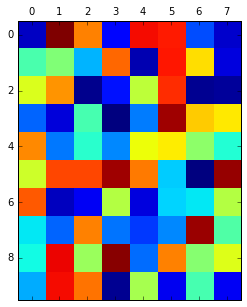

In [85]:
# let's create a fake DEM with some random data
import numpy as np
dem = abs(np.random.rand(isnobal_params['nlines'], isnobal_params['nsamps']))

%matplotlib inline
import matplotlib.pyplot as plt
plt.matshow(dem)

In [86]:
np.shape(dem)

(10, 8)

In [87]:
np.shape(nc.variables['z'])

(10, 8)

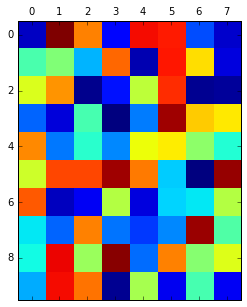

In [88]:
# use [:] to unpack and assign te values from the dem
nc.variables['z'][:] = dem
z = nc.variables['z'][:]
plt.matshow(z)

We see that our fake dem is now contained in the `z` variable of the netcdf. You can optionally also insert the elevation data into the `alt` variable, but mostly the `alt` variable remains unused and is not required for iSNOBAL.

Now we'll create a series of 5 (100, 10) random arrays to simulate five timesteps worth of data. We'll assign this to be fake atmospheric temperature.

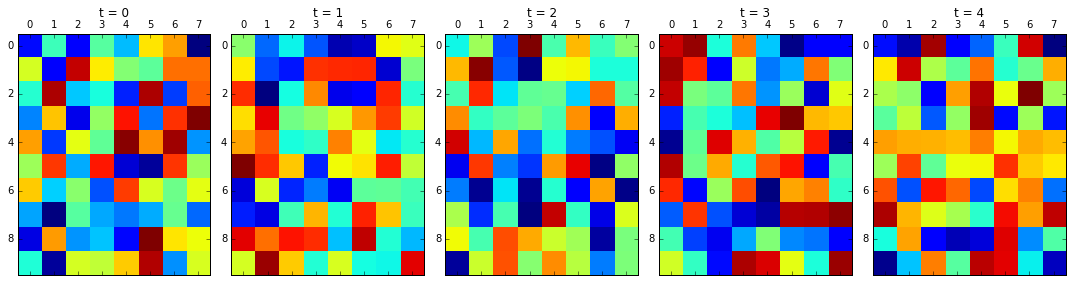

In [84]:
fake_ta = abs(np.random.rand(5, isnobal_params['nlines'], isnobal_params['nsamps']))
ta = nc.variables['T_a']  # np.shape(ta) == (0, 100, 10) at this point

# ta is a reference to the actual netcdf variable, so we can assign to it
ta[:] = fake_ta  # now np.shape(ta) == (5, 100, 10)

# double click the image below to enlarge and check they are different
f, axs = plt.subplots(1, 5, figsize=(15, 10))

for idx, ax in enumerate(axs):
    ax.matshow(ta[idx])
    ax.set_title('t = ' + str(idx))
    